In [1]:
import sklearn
from sklearn.datasets import make_circles
import torch
import torch.nn as nn


torch.set_default_dtype(torch.float64)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

len(X), len(y)

(1000, 1000)

In [2]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [3]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({
    "X1": X[:,0],
    "X2": X[:,1],
    "label": y
})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


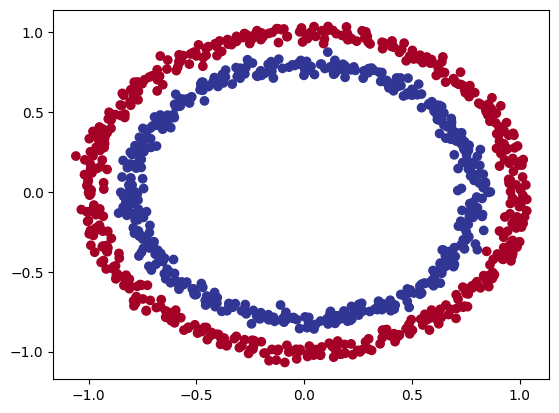

In [4]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [5]:
# Turn data into tensors


X = torch.from_numpy(X).type(torch.float64)
y = torch.from_numpy(y).type(torch.float64)

X[:5], y[:5]

# Split data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
# X_train, X_test, y_train, y_test = X_train.type(torch.double), X_test.type(torch.double), y_train.type(torch.double), y_test.type(torch.double),


In [6]:
## 2. Build a model (to classify the blue and red dots)

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # 2. Create layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2,
                             out_features=5)
    self.layer_2 = nn.Linear(in_features=5,
                             out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [7]:
device

'cpu'

In [8]:
# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100

  return acc

In [9]:
# Building training and testing loop

# Set number of epochs
epochs = 100

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
model_0.to(device)
for epoch in range(epochs):
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits.to(device),
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Calculate test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.70190 | Acc: 50.00% | Test loss: 0.70574 | Test acc: 50.00%
Epoch: 10 | Loss: 0.69611 | Acc: 55.25% | Test loss: 0.70070 | Test acc: 51.50%
Epoch: 20 | Loss: 0.69449 | Acc: 52.38% | Test loss: 0.69907 | Test acc: 50.00%
Epoch: 30 | Loss: 0.69395 | Acc: 52.00% | Test loss: 0.69831 | Test acc: 48.50%
Epoch: 40 | Loss: 0.69370 | Acc: 51.00% | Test loss: 0.69779 | Test acc: 49.00%
Epoch: 50 | Loss: 0.69354 | Acc: 51.25% | Test loss: 0.69737 | Test acc: 48.50%
Epoch: 60 | Loss: 0.69343 | Acc: 51.00% | Test loss: 0.69701 | Test acc: 47.00%
Epoch: 70 | Loss: 0.69334 | Acc: 51.38% | Test loss: 0.69670 | Test acc: 47.00%
Epoch: 80 | Loss: 0.69328 | Acc: 51.38% | Test loss: 0.69644 | Test acc: 47.00%
Epoch: 90 | Loss: 0.69322 | Acc: 51.38% | Test loss: 0.69620 | Test acc: 47.00%


In [10]:
# Making prediction and evaluation
import requests
from pathlib import Path

# Download helper function if not downloaded
if Path("helper_functions.py").is_file():
  print("Helper functions already exists, skipping download")
else:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
  print("Downloaded helper_functions.py")
from helper_functions import plot_predictions

Downloaded helper_functions.py


In [11]:
import numpy as np

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel())))

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())



In [12]:
X_train.dtype

torch.float64

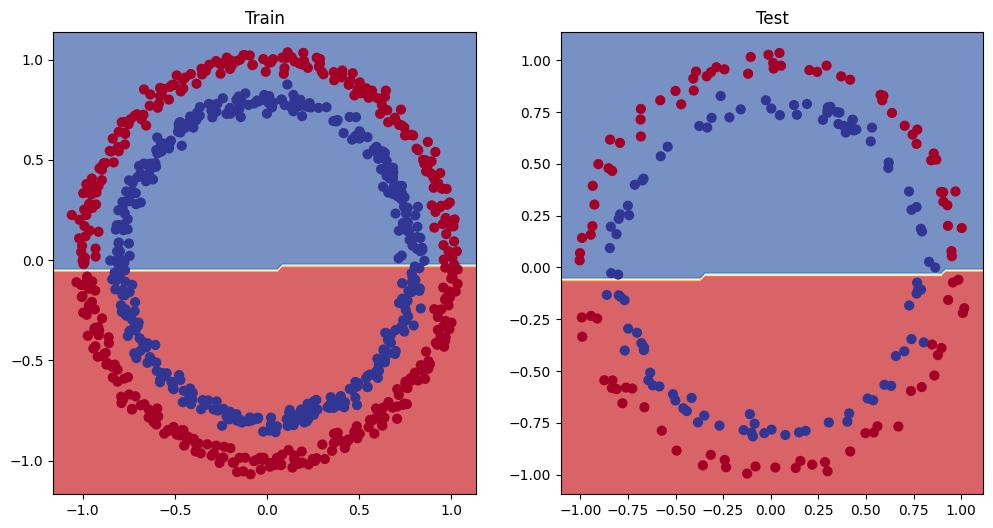

In [13]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [14]:
### Improving the model (from model perspective)
# Adding more hidden units: 5 -> 10
# Increase the number of layers 2 -> 3
# Increase the number of epochs 100 -> 1000


class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(x)
    # z = self.layer_3(x)
    # return z
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [15]:
# Create loass function
loss_fn = nn.BCEWithLogitsLoss()
# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)


In [16]:
# write training and evaluation loop for model_1
torch.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  # Training
  model_1.train()
  # 1. FOrward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))  # logits -> pred probabilities -> predi


  # 2. Calcuate the loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward propagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate loss
    tet_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")



Epoch: 0 | loss: 0.69611 | Acc: 58.75% | Test loss: 0.69602 | Test acc: 58.00%
Epoch: 100 | loss: 0.69299 | Acc: 50.75% | Test loss: 0.69602 | Test acc: 45.50%
Epoch: 200 | loss: 0.69298 | Acc: 51.25% | Test loss: 0.69602 | Test acc: 45.00%
Epoch: 300 | loss: 0.69298 | Acc: 51.62% | Test loss: 0.69602 | Test acc: 45.00%
Epoch: 400 | loss: 0.69298 | Acc: 51.25% | Test loss: 0.69602 | Test acc: 45.00%
Epoch: 500 | loss: 0.69298 | Acc: 51.12% | Test loss: 0.69602 | Test acc: 45.50%
Epoch: 600 | loss: 0.69298 | Acc: 51.12% | Test loss: 0.69602 | Test acc: 46.00%
Epoch: 700 | loss: 0.69298 | Acc: 51.00% | Test loss: 0.69602 | Test acc: 46.00%
Epoch: 800 | loss: 0.69298 | Acc: 51.00% | Test loss: 0.69602 | Test acc: 46.00%
Epoch: 900 | loss: 0.69298 | Acc: 51.00% | Test loss: 0.69602 | Test acc: 46.00%


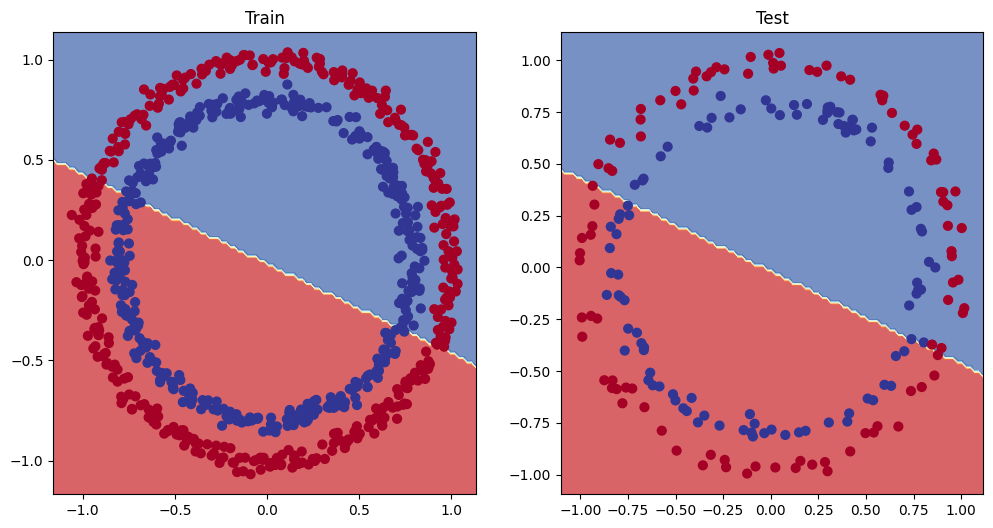

In [17]:
# Plot the decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [18]:
# Preparing data for straight line

weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Create train and test split
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]


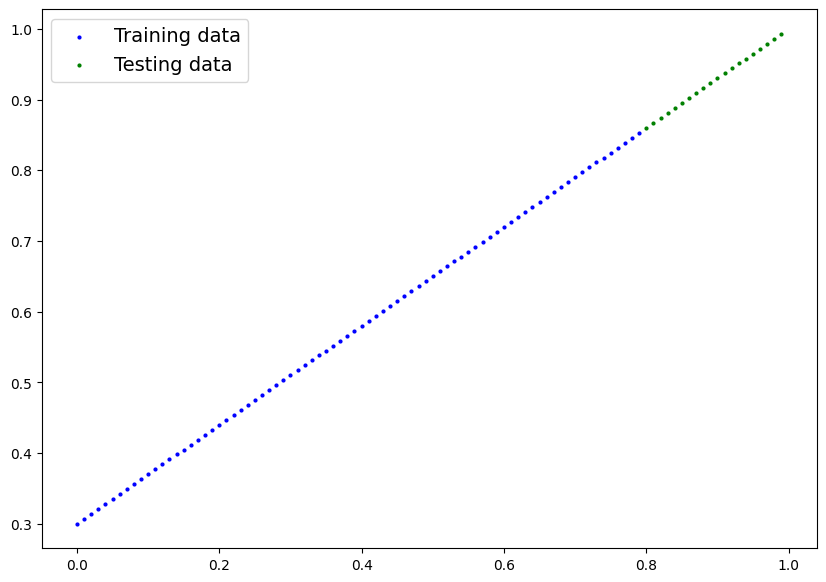

In [19]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

In [20]:
# Create another model with the same architecture as model_1 (but using nn.Sequestial())

model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [21]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)


In [22]:
# Train the model

torch.manual_seed(42)

epochs = 1000

# Put data on the device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ## Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)


    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | loss: {loss:.5f} | Test loss: {test_loss:.5f}")




Epoch: 0 | loss: 1.09425 | Test loss: 0.95315
Epoch: 100 | loss: 0.10132 | Test loss: 0.02226
Epoch: 200 | loss: 0.07298 | Test loss: 0.03340
Epoch: 300 | loss: 0.06017 | Test loss: 0.01880
Epoch: 400 | loss: 0.07073 | Test loss: 0.01824
Epoch: 500 | loss: 0.06362 | Test loss: 0.02558
Epoch: 600 | loss: 0.05548 | Test loss: 0.01049
Epoch: 700 | loss: 0.05856 | Test loss: 0.01294
Epoch: 800 | loss: 0.05646 | Test loss: 0.01500
Epoch: 900 | loss: 0.06798 | Test loss: 0.01028


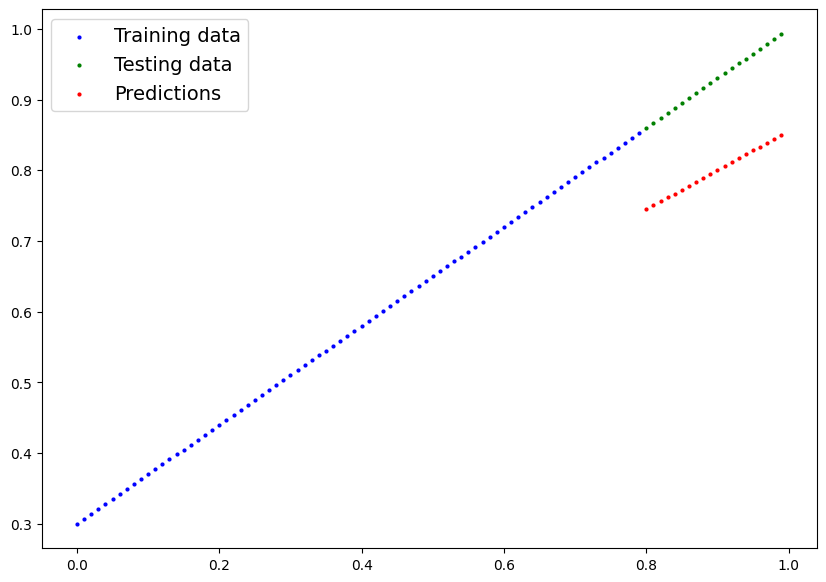

In [23]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

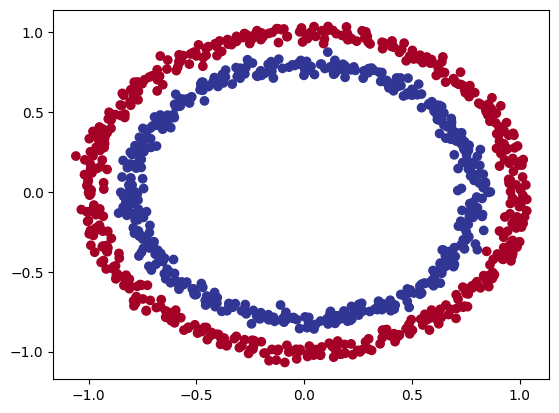

In [24]:
# Recreating the model with the missing piec: non-linearity

import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [25]:
# Convert data to tensors and then to train and test splits

import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float64)
y = torch.from_numpy(y).type(torch.float64)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [26]:
# Building a model with non-linear activation function

from torch import nn

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_3 = CircleModelV2().to(device)
model_3


CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [27]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)



In [28]:
torch.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

model_3.to(device)
for epoch in range(epochs):
  model_3.train()
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=test_pred,
                           y_pred=test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70701 | Acc: 50.00% | Test loss: 0.70449 | Test acc: 100.00%
Epoch: 100 | Loss: 0.69100 | Acc: 56.12% | Test loss: 0.69123 | Test acc: 100.00%
Epoch: 200 | Loss: 0.68901 | Acc: 57.38% | Test loss: 0.69045 | Test acc: 100.00%
Epoch: 300 | Loss: 0.68654 | Acc: 58.50% | Test loss: 0.68945 | Test acc: 100.00%
Epoch: 400 | Loss: 0.68307 | Acc: 58.75% | Test loss: 0.68780 | Test acc: 100.00%
Epoch: 500 | Loss: 0.67815 | Acc: 59.00% | Test loss: 0.68512 | Test acc: 100.00%
Epoch: 600 | Loss: 0.67127 | Acc: 58.88% | Test loss: 0.68086 | Test acc: 100.00%
Epoch: 700 | Loss: 0.66170 | Acc: 59.25% | Test loss: 0.67423 | Test acc: 100.00%
Epoch: 800 | Loss: 0.64782 | Acc: 60.88% | Test loss: 0.66184 | Test acc: 100.00%
Epoch: 900 | Loss: 0.62583 | Acc: 65.25% | Test loss: 0.63961 | Test acc: 100.00%


In [29]:
# Make predictions
model_3.to(device)
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10]

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])

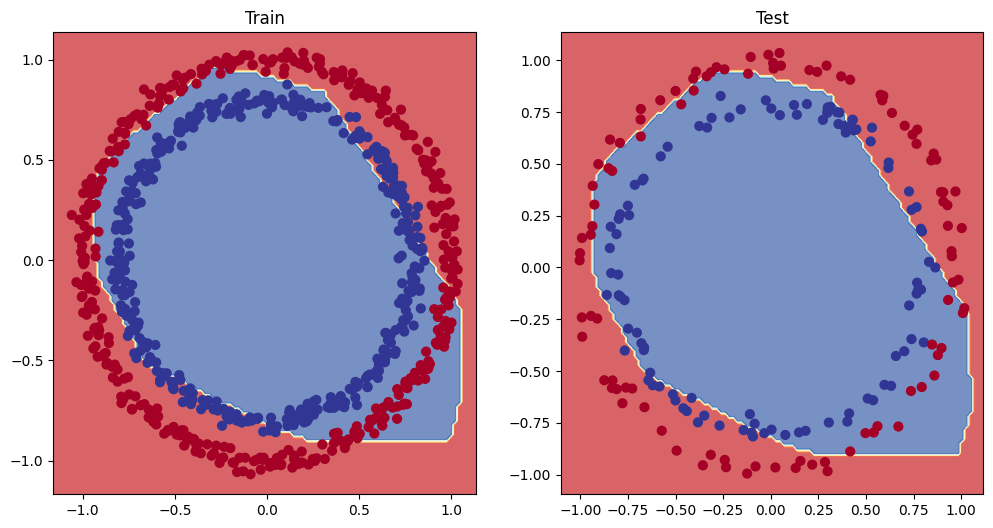

In [30]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)


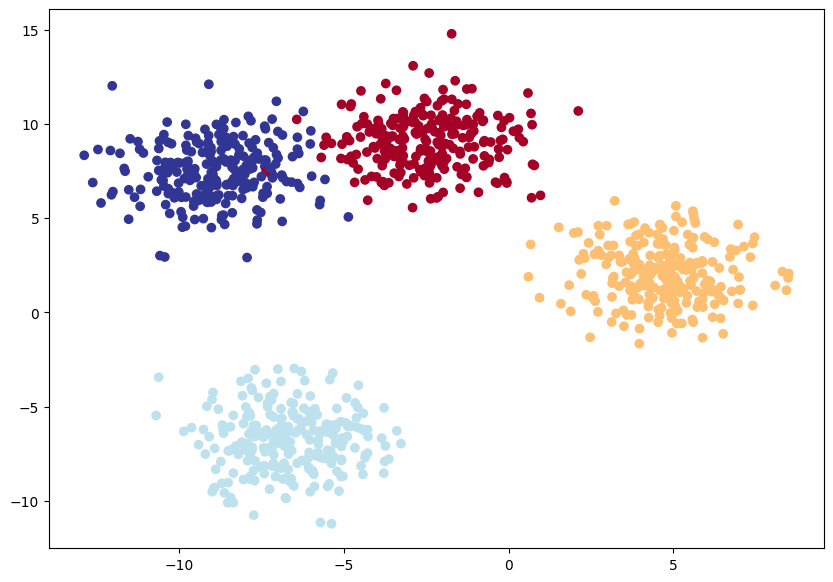

In [31]:
# Creating multi-class dataset
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy (X_blob).type(torch.float64)
y_blob = torch.from_numpy (y_blob).type(torch.LongTensor)

# 3. Split into train and test data
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                       y_blob,
                                                                       test_size=0.2,
                                                                       random_state=RANDOM_SEED)


# 4. Plot data (Visualize)
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

In [32]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

In [53]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """
          Initialize multi-classification model
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(
                  input_features=2,
                  output_features=4,
                  hidden_units=8
).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [54]:
# Create a loss function and an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

In [55]:
# Getting some raw outputs of the model (logits)
model_4.eval()
with torch.inference_mode():
  y_preds = model_4(X_blob.type(torch.float64).to(device))

y_preds[:10]

tensor([[ 0.0288, -0.8068,  0.4406,  0.3512],
        [-1.1618, -1.2779, -0.2850,  0.4172],
        [-1.2113, -1.3272, -0.3121,  0.4264],
        [-0.2230, -0.2594,  0.0170,  0.3950],
        [-0.2066, -0.2744,  0.0553,  0.3747],
        [-1.2689, -1.3803, -0.3440,  0.4339],
        [-0.3009, -0.1813, -0.1840,  0.5020],
        [-1.1308, -1.2479, -0.2680,  0.4120],
        [-1.1236, -1.2491, -0.2638,  0.4118],
        [-0.2778, -0.2006, -0.1353,  0.4763]])

In [56]:
y_logits = model_4(X_blob_test.type(torch.float64).to(device))

# Converting our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.3265, -0.1580, -0.2433,  0.5334],
        [ 0.0573, -0.7623,  0.4978,  0.3550],
        [-1.3058, -1.4240, -0.3633,  0.4461],
        [-0.2283, -0.2549,  0.0055,  0.4011],
        [-0.2332, -0.1378, -0.3252,  0.5839]], grad_fn=<SliceBackward0>)
tensor([[0.1775, 0.2101, 0.1929, 0.4195],
        [0.2304, 0.1015, 0.3579, 0.3103],
        [0.0978, 0.0869, 0.2511, 0.5641],
        [0.1955, 0.1904, 0.2471, 0.3669],
        [0.1895, 0.2085, 0.1729, 0.4291]], grad_fn=<SliceBackward0>)


In [57]:
torch.argmax(y_pred_probs[0])

tensor(3)

In [58]:
torch.sum(y_pred_probs[0])

# Convert our model's prediction into prediction labels

y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 2, 3, 3, 3,
        3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2,
        3, 2, 3, 2, 3, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 2,
        3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3,
        3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 2, 3, 3, 3])

In [59]:
# Create a training and testing loop
torch.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()

  y_logits = model_4(X_blob_train.type(torch.float64))
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test.type(torch.float64))
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f} | Acc: {acc:.2f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}" )


Epoch: 0 | Loss: 1.4153 | Acc: 11.88 | Test loss: 0.5974 | Test acc: 28.00
Epoch: 10 | Loss: 0.6512 | Acc: 89.88 | Test loss: 0.5974 | Test acc: 96.00
Epoch: 20 | Loss: 0.2552 | Acc: 99.00 | Test loss: 0.5974 | Test acc: 99.50
Epoch: 30 | Loss: 0.1217 | Acc: 99.12 | Test loss: 0.5974 | Test acc: 99.50
Epoch: 40 | Loss: 0.0780 | Acc: 99.12 | Test loss: 0.5974 | Test acc: 99.50
Epoch: 50 | Loss: 0.0595 | Acc: 99.12 | Test loss: 0.5974 | Test acc: 99.50
Epoch: 60 | Loss: 0.0497 | Acc: 99.12 | Test loss: 0.5974 | Test acc: 99.50
Epoch: 70 | Loss: 0.0439 | Acc: 99.12 | Test loss: 0.5974 | Test acc: 99.50
Epoch: 80 | Loss: 0.0400 | Acc: 99.12 | Test loss: 0.5974 | Test acc: 99.50
Epoch: 90 | Loss: 0.0373 | Acc: 99.12 | Test loss: 0.5974 | Test acc: 99.50


In [60]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

y_logits[:10]

# go from ogits -> Prediction probablities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

# Go from pred probs to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

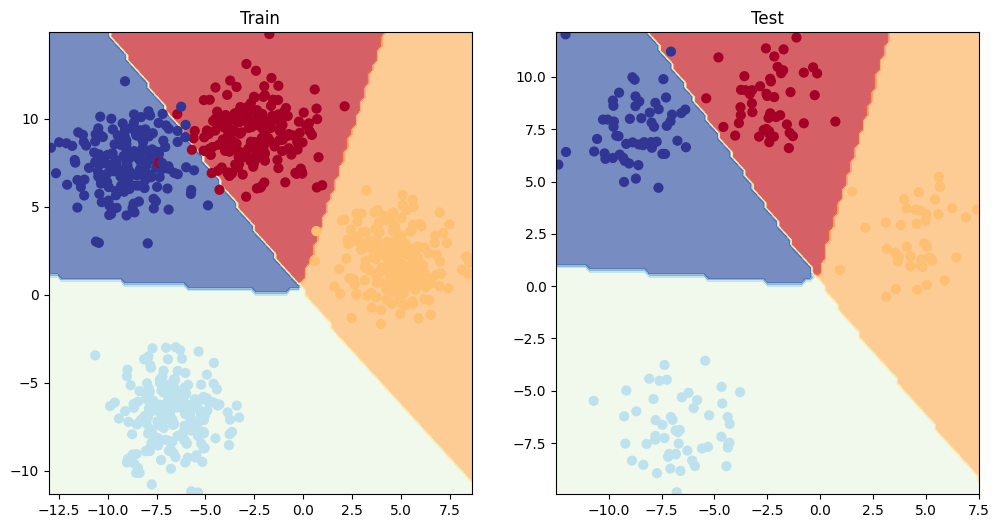

In [61]:
# Visualize

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)